In [4]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [5]:
def visualization(title, original_labels, data_clustering, student_labels):
    print("\n---------------------------------------------------------\n")
    print(title + " Visualization\n")

    # Original
    plt.scatter(data_clustering[:100, 0], data_clustering[:100, 3], c = original_labels[:100])
    plt.title("Original")
    plt.show()

    # Student
    plt.scatter(data_clustering[:100, 0], data_clustering[:100, 3], c = student_labels[:100])
    plt.title("Student")
    plt.show()

    # Original 3D
    fig = plt.figure() # make 3d fig
    ax = Axes3D(fig)
    ax.scatter(data_clustering[:100, 3], data_clustering[:100, 0], data_clustering[:100, 2], c = original_labels[:100], edgecolor = 'k')
    plt.title("Original")
    plt.show()

    # Student 3D
    fig = plt.figure() # make 3d fig
    ax = Axes3D(fig)
    ax.scatter(data_clustering[:100, 3], data_clustering[:100, 0], data_clustering[:100, 2], c = student_labels[:100], edgecolor = 'k')
    plt.title("Student")
    plt.show()
    print("\n---------------------------------------------------------\n")

In [7]:
data = pd.read_csv("../Data/data.csv", sep=';')

In [8]:
# Question 1 - Data Cleaning #

# Convert float format from '0,1' to '0.1'. Also in this data set all numpy.object types are floats
for i in data.columns:
    if(data[i].dtype == np.object):
        for j in range(data[i].size):
            tmp = []
            tmp = data[i][j].split(",")
            if (tmp != []):
                try:
                    data[i][j] = np.float64(tmp[0] + '.' + tmp[1])
                except:
                    pass
        data[i] = pd.to_numeric(data[i])

# Drop negative values except column -> 'Tendency'
for i in data.columns[:-3]:
     data = data.drop(data[data['LB'] < 0].index)

# Drop if heart bpm < 60
data = data.drop(data[data['LB'] < 60].index)

# Drop if heart bpm > 200
data = data.drop(data[data['LB'] > 200].index)

# Drop duplicate rows
data = data.drop_duplicates()

# Drop rows with NaN values
data = data.dropna()

print("\n----------------------------------------------------------------\n")
data.info()
print("\n----------------------------------------------------------------\n")
data.head()

# Data is ready

<ipython-input-8-1c49e306ded5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i][j] = np.float64(tmp[0] + '.' + tmp[1])



----------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2115 entries, 0 to 2125
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LB        2115 non-null   int64  
 1   AC        2115 non-null   float64
 2   FM        2115 non-null   float64
 3   UC        2115 non-null   float64
 4   DL        2115 non-null   float64
 5   DS        2115 non-null   float64
 6   DP        2115 non-null   float64
 7   ASTV      2115 non-null   int64  
 8   MSTV      2115 non-null   float64
 9   ALTV      2115 non-null   int64  
 10  MLTV      2115 non-null   float64
 11  Width     2115 non-null   int64  
 12  Min       2115 non-null   int64  
 13  Max       2115 non-null   int64  
 14  Nmax      2115 non-null   int64  
 15  Nzeros    2115 non-null   int64  
 16  Mode      2115 non-null   int64  
 17  Mean      2115 non-null   int64  
 18  Median    2115 non-null   int64  
 19  Va

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
0,120,0.000,0.0,0.000,0.000,0.0,0.0,73,0.5,43,...,126,2,0,120,137,121,73,1,9,2
1,132,0.006,0.0,0.006,0.003,0.0,0.0,17,2.1,0,...,198,6,1,141,136,140,12,0,6,1
2,133,0.003,0.0,0.008,0.003,0.0,0.0,16,2.1,0,...,198,5,1,141,135,138,13,0,6,1
3,134,0.003,0.0,0.008,0.003,0.0,0.0,16,2.4,0,...,170,11,0,137,134,137,13,1,6,1
4,132,0.007,0.0,0.008,0.000,0.0,0.0,16,2.4,0,...,170,9,0,137,136,138,11,1,2,1



-----------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2115 entries, 0 to 2125
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LB      2115 non-null   int64  
 1   AC      2115 non-null   float64
 2   FM      2115 non-null   float64
 3   UC      2115 non-null   float64
 4   DL      2115 non-null   float64
 5   DS      2115 non-null   float64
 6   DP      2115 non-null   float64
 7   ASTV    2115 non-null   int64  
 8   MSTV    2115 non-null   float64
 9   ALTV    2115 non-null   int64  
 10  MLTV    2115 non-null   float64
dtypes: float64(8), int64(3)
memory usage: 198.3 KB

-----------------------------------------------------------------

Find the best number of clusters with SSE & Elbow Method.



<ipython-input-9-bffbe1db9602>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clustering["clusters"] = kmeans.labels_
<ipython-input-9-bffbe1db9602>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clustering["clusters"] = kmeans.labels_
<ipython-input-9-bffbe1db9602>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

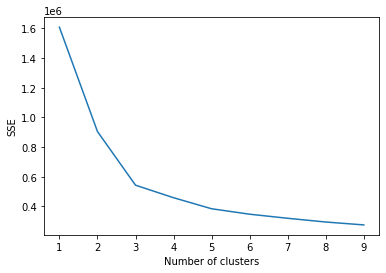


So, the best number of clusters is 3.

K = 3

-----------------------------------------------------------------



In [9]:
# Question 2 - Clustering

# Data preparation for Clustering
data_clustering = data[data.columns[:-12]]
data_clustering.head()
print("\n-----------------------------------------------------------------\n")
data_clustering.info()

# 1) Find the best number of clusters (SSE / Elbow Method)
print("\n-----------------------------------------------------------------\n")
print("Find the best number of clusters with SSE & Elbow Method.\n")
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k).fit(data_clustering)
    data_clustering["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

print("\nSo, the best number of clusters is 3.\n\nK = 3")
print("\n-----------------------------------------------------------------\n")

original_labels = data['NSP'].copy()

# 2) Standard Scaler
data_clustering = StandardScaler().fit_transform(data_clustering)    

In [7]:
# K-Means #

# Student
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans = kmeans.fit(data_clustering)
student_labels = kmeans.labels_


---------------------------------------------------------

K-Means Visualization



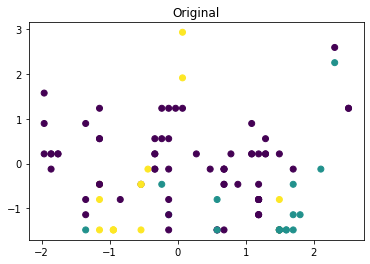

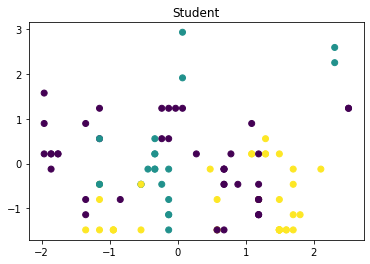

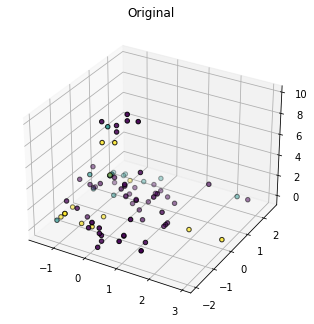

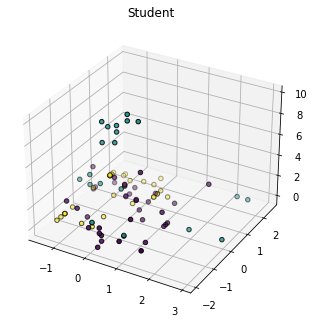


---------------------------------------------------------



In [8]:
# Visualization
visualization("K-Means", original_labels, data_clustering, student_labels)


---------------------------------------------------------



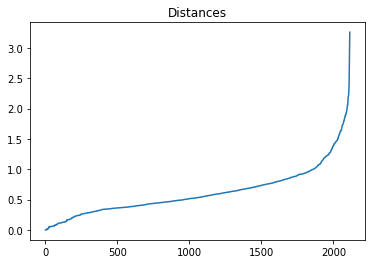


EPS = 1.0

---------------------------------------------------------



In [10]:
print("\n---------------------------------------------------------\n")

# Find the best eps (Elbow method)
neigh = NearestNeighbors(n_neighbors = 11)
nbrs = neigh.fit(data_clustering)
distances, indices = nbrs.kneighbors(data_clustering)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.title("Distances")
plt.show()
print("\nEPS = 1.0")

print("\n---------------------------------------------------------\n")

In [10]:
# DBSCAN #

# Student
dbscan = DBSCAN(eps = 1.0, min_samples=2 * 11)
dbscan = dbscan.fit(data_clustering)
student_labels = dbscan.labels_


---------------------------------------------------------

DBSCAN Visualization



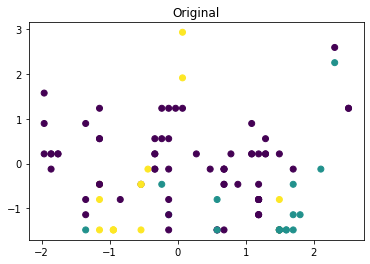

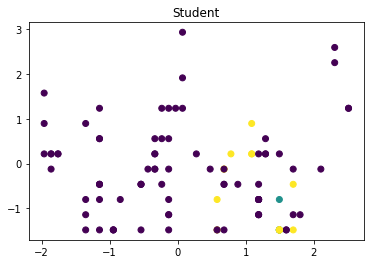

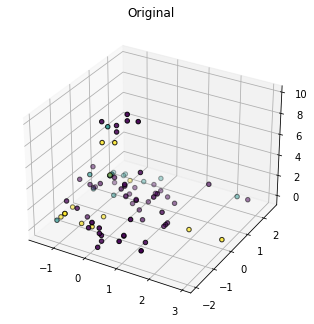

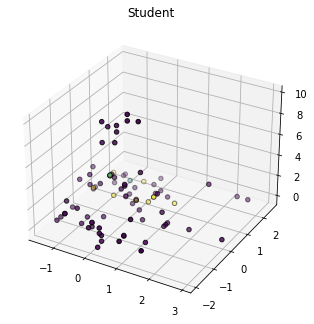


---------------------------------------------------------



In [11]:
# Visualization
visualization("DBSCAN", original_labels, data_clustering, student_labels)

In [12]:
# Optics

# Student
optics = OPTICS(min_samples=5, max_eps=80) # define the model
optics = optics.fit(data_clustering) # fit the model
labels = optics.labels_


---------------------------------------------------------

OPTICS Visualization



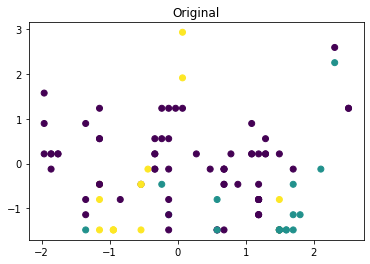

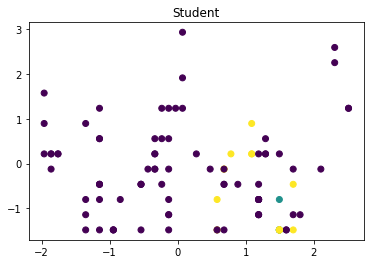

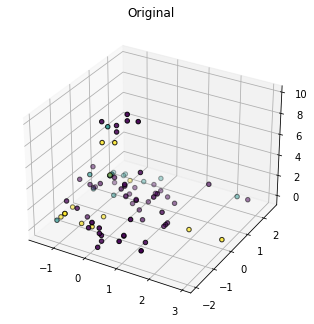

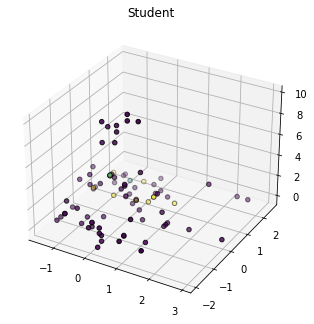


---------------------------------------------------------



In [13]:
# Visualization
visualization("OPTICS", original_labels, data_clustering, student_labels)

In [14]:
# Question 3 - Classification #

# Initializing data_classification
data_classification = data[data.columns[:-2]]
fhr = data[data.columns[-2]]
data_classification = StandardScaler().fit_transform(data_classification)

In [15]:
# Preparation of data #
X = data_classification.astype(float)
Y = fhr

# Convert data to dummy variables
encoder = LabelEncoder().fit(Y)
y_bool = encoder.transform(Y)
y = np_utils.to_categorical(y_bool)

# Split data into train and test
len_data = X.shape[0]
train_size = int(len_data * .6)
test_size = int(len_data * .3)
valid_size = int(len_data * .1)
print ("Train size: %d" % train_size)
print ("Test size: %d" % test_size)
print ("Validation size: %d" % valid_size)

xtr = X[:train_size,:]
ytr = y[:train_size,:]
ytr_bool = y_bool[:train_size]

xva = X[train_size:train_size+valid_size,:]
yva = y[train_size:train_size+valid_size,:]
yva_bool = y_bool[train_size:train_size+valid_size]

xte = X[train_size+valid_size:,:]
yte = y[train_size+valid_size:,:]
yte_bool = y_bool[train_size+valid_size:]

Train size: 1275
Test size: 637
Validation size: 212


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 350)               7700      
_________________________________________________________________
dense_17 (Dense)             (None, 50)                17550     
_________________________________________________________________
dense_18 (Dense)             (None, 10)                510       
Total params: 25,760
Trainable params: 25,760
Non-trainable params: 0
_________________________________________________________________
None


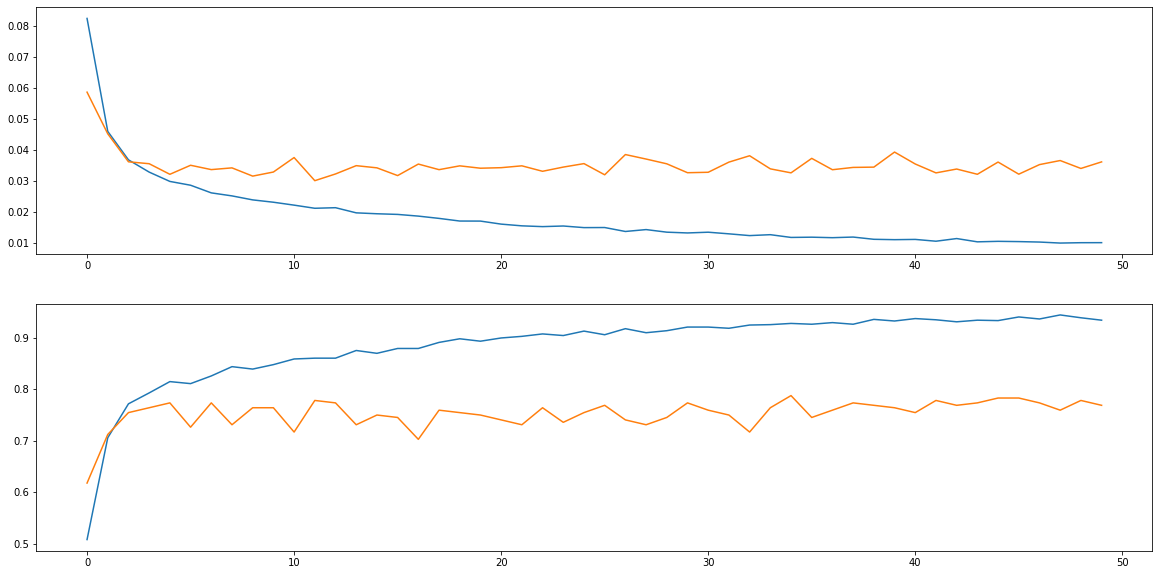

Train accuracy: 93.96%


c:\users\georg\appdata\local\programs\python\python39\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Train Accuracy by model.predict: 93.96%
Val Accuracy by model.predict: 76.89%
Test Accuracy by model.predict: 56.81%
Train MMC:  0.9280082791084835
Val MMC:  0.7059896648598883
Test MMC:  0.5117390727572328
---------------TRAIN---------------------
[[259   2   1   0   0   1   1   0   0   4]
 [ 11 333   0   1   0   1   0   0   0   0]
 [  8   0  31   0   0   0   0   0   0   0]
 [  0   0   0  71   0   0   0   0   0   0]
 [  4   0   0   0  36   0   0   0   0   4]
 [  2   1   0   0   0 121   1   0   0   0]
 [  0   0   0   0   0   0 113   0   0   0]
 [  0   0   1   0   0   0  11   0   1   0]
 [  0   0   0   0   0   0   0   0  50  19]
 [  3   0   0   0   0   0   0   0   0 184]]
---------------VAL---------------------
[[17  0  0  1  0  0  0  0  0]
 [ 4 54  6  2  1  0  0  1  0]
 [ 0  0  3  0  0  0  0  0  0]
 [ 7  2  0  9  0  0  0  0  0]
 [ 0  6  0  0 51  4  0  0  0]
 [ 0  0  0  0  9 25  0  0  0]
 [ 0  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  4]]
---------

In [50]:
# Define the Model v1
model = Sequential()
model.add(Dense(350, input_dim = 21, activation = 'relu'))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(10, activation = 'sigmoid'))

# Compile the Model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# from keras.utils import plot_model
# plot_model(model, to_file='model.png')

# Fit model
history = model.fit(xtr, ytr, 
                    validation_data=(xva, yva), 
                    epochs=50, 
                    batch_size=10,
                    verbose=0)

# Plot training and validation loss
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

# Evaluate and Predict
scores = model.evaluate(xtr, ytr, verbose=0)
print("Train %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

ytr_pred = model.predict_classes(xtr, verbose=0)
print("Train Accuracy by model.predict: %.2f%%" % (100*sum(ytr_bool == ytr_pred)/ytr.shape[0]))

# make class predictions with the model
yva_pred = model.predict_classes(xva, verbose=0)
print("Val Accuracy by model.predict: %.2f%%" % (100*sum(yva_bool == yva_pred)/yva.shape[0]))

# make class predictions with the model
yte_pred = model.predict(xte, batch_size=1, verbose=0)
yte_pred_bool = np.argmax(yte_pred, axis=1)

print("Test Accuracy by model.predict: %.2f%%" % (100*sum(yte_bool == yte_pred_bool)/yte.shape[0]))

# Matthews correlation coefficient
print("Train MMC: ", matthews_corrcoef(ytr_bool, ytr_pred))
print("Val MMC: ", matthews_corrcoef(yva_bool, yva_pred))
print("Test MMC: ", matthews_corrcoef(yte_bool, yte_pred_bool))

print("---------------TRAIN---------------------")
print(confusion_matrix(ytr_bool, ytr_pred))
print("---------------VAL---------------------")
print(confusion_matrix(yva_bool, yva_pred))
print("---------------TEST---------------------")
print(confusion_matrix(yte_bool, yte_pred_bool))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 500)               11000     
_________________________________________________________________
dense_20 (Dense)             (None, 100)               50100     
_________________________________________________________________
dense_21 (Dense)             (None, 10)                1010      
Total params: 62,110
Trainable params: 62,110
Non-trainable params: 0
_________________________________________________________________
None


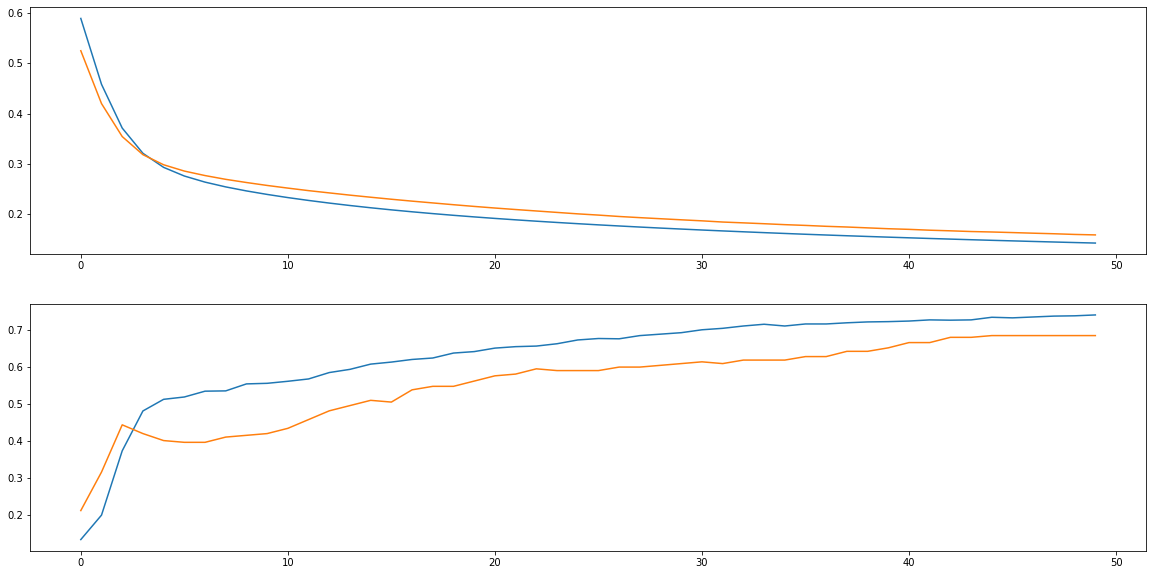

Train accuracy: 74.35%


c:\users\georg\appdata\local\programs\python\python39\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Train Accuracy by model.predict: 74.35%
Val Accuracy by model.predict: 68.40%
Test Accuracy by model.predict: 48.36%
Train MMC:  0.6890356070985061
Val MMC:  0.6085232940546534
Test MMC:  0.41449088963720904
---------------TRAIN---------------------
[[218  26   0   0   0   0   1   0   0  23]
 [ 20 316   0   4   0   5   0   0   0   1]
 [ 30   9   0   0   0   0   0   0   0   0]
 [  0  22   0  49   0   0   0   0   0   0]
 [ 22   6   0   1   0   0   0   0   0  15]
 [  1  29   0   1   0  78  16   0   0   0]
 [ 12   0   0   0   0   4  96   0   0   1]
 [  0   0   0   0   0   1   5   7   0   0]
 [  4   0   0   0   0   0   0   0  29  36]
 [ 21   3   0   0   0   0   1   0   7 155]]
---------------VAL---------------------
[[15  1  0  0  0  0  0  2]
 [ 5 57  3  0  0  0  0  3]
 [ 0  2  1  0  0  0  0  0]
 [13  1  1  1  0  0  0  2]
 [ 0  7  0  0 40 14  0  0]
 [ 2  0  0  0  3 29  0  0]
 [ 0  0  0  0  0  4  0  0]
 [ 4  0  0  0  0  0  0  2]]
---------------TEST---------------------
[[ 41   2   0   0   0

In [51]:
# Define the Model v2
model = Sequential()
model.add(Dense(500, input_dim = 21, activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(10, activation = 'sigmoid'))

# Compile the Model
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

print(model.summary())

# from keras.utils import plot_model
# plot_model(model, to_file='model.png')

# Fit model
history = model.fit(xtr, ytr, 
                    validation_data=(xva, yva), 
                    epochs=50, 
                    batch_size=10,
                    verbose=0)

# Plot training and validation loss
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

# Evaluate and Predict
scores = model.evaluate(xtr, ytr, verbose=0)
print("Train %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

ytr_pred = model.predict_classes(xtr, verbose=0)
print("Train Accuracy by model.predict: %.2f%%" % (100*sum(ytr_bool == ytr_pred)/ytr.shape[0]))

# make class predictions with the model
yva_pred = model.predict_classes(xva, verbose=0)
print("Val Accuracy by model.predict: %.2f%%" % (100*sum(yva_bool == yva_pred)/yva.shape[0]))

# make class predictions with the model
yte_pred = model.predict(xte, batch_size=1, verbose=0)
yte_pred_bool = np.argmax(yte_pred, axis=1)

print("Test Accuracy by model.predict: %.2f%%" % (100*sum(yte_bool == yte_pred_bool)/yte.shape[0]))

# Matthews correlation coefficient
print("Train MMC: ", matthews_corrcoef(ytr_bool, ytr_pred))
print("Val MMC: ", matthews_corrcoef(yva_bool, yva_pred))
print("Test MMC: ", matthews_corrcoef(yte_bool, yte_pred_bool))

print("---------------TRAIN---------------------")
print(confusion_matrix(ytr_bool, ytr_pred))
print("---------------VAL---------------------")
print(confusion_matrix(yva_bool, yva_pred))
print("---------------TEST---------------------")
print(confusion_matrix(yte_bool, yte_pred_bool))